# Cost-Optimal Task Scheduling in Battery Assisted Mobile Edge Computing

## Baseline

$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[\sum_{j\in\mathcal{B},j\neq i}\frac{p_i c_i^G}{\mu_i}x_{ji} + \sum_{j\in\mathcal{B},j\neq i}\left(c_{ij}-\frac{p_i c_i^G}{\mu_i}\right)x_{ij}\right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

Let 
$$
a_i = \frac{p_i c_i^G}{\mu_i}\quad b_{ij}=\left(c_{ij}-\frac{p_i c_i^G}{\mu_i}\right)
$$
The problem is reformualted as follows.
$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}a_i x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} b_{ij}x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

<img src="networkflow.png" alt="Drawing" style="width: 600px;"/>

The weight $(u,v)$ from node $u$ to node $v$ follows
$
w_{uv} = a_v + b_{uv} 
$

## Subproblem 1

$
\begin{align}
\min_{\mathbf{x}} \quad & \sum_{i}\left[ \sum_{j\in\mathcal{B}, j\neq i}\left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right)x_{ji} + \sum_{j\in\mathcal{B}, j\neq i} \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)x_{ij} \right] \\
s.t. \quad & \sum_{j\in\mathcal{B}, j\neq i} x_{ij}\leq \lambda_i,~i\in\mathcal{B} \\
           & x_{ij}\in\mathbb{N},~i,j\in\mathcal{B},~i\neq j
\end{align}
$

Let 
$$
a_i = \left(\frac{p_i c_i^G}{\mu_i} - \frac{p_i\pi_i}{\mu_i}\right) \quad b_{ij} = \left(c_{ij} - \frac{p_i c_i^G}{\mu_i} + \frac{p_i\pi_i}{\mu_i} \right)
$$
The problem is reformualted the same as the baseline. 


## Subproblem 2

$$
\forall i\in\mathcal{B}  \quad \min_{0\leq P\leq P_i^S} \sum_{i}\left[ \alpha \left(\frac{P}{P_i^S}\right)^{k_p} - P(c_i^G-c_i^D-\pi_i) \right]
$$

Define
$$
g(P) = \alpha \left(\frac{P}{P_i^S}\right)^{k_p} - P(c_i^G-c_i^D-\pi_i)
$$
Let
$$
a_{i} = \frac{\alpha}{(P_i^S)^{k_p}}\quad b_i = (c_i^G-c_i^D-\pi_i)
$$
Then 
$$
g(P) = a_i P^{k_p} -b_i P
$$
And 
$$
g'(P) = a_i k_p P^{k_p-1} - b_i
$$

Therefore
$$
P^{*} = \left\{
\begin{array}{ll}
\left(\frac{b_i}{a_i k_p}\right)^{\frac{1}{k_p-1}} & b_i \geq 0 \\
 0 & \text{otherwise}
\end{array}\right.
$$


In [188]:
%reload_ext autoreload
%autoreload 2
%aimport src

from src.sp1 import NetworkFlowProblem
import numpy as np
from src.optimization import Problem, BaselineProblem

N_list = [10, 20, 30, 40, 50]
M = 20

obj_list = []
obj_baseline_list = []
dual_bound_list =[]


for N in N_list:
    for k in range(M):

        lam = np.random.uniform(low=20, high=50, size=N).round()
        mu = np.random.uniform(low=1, high=5, size=N).round()
        p = np.ones(N) 
        cG = np.random.uniform(low=0.5, high=2, size=N).round()
        cD = np.ones(N) / 3
        C = np.random.randint(0,10,size = (N,N))*0.1
        alpha = 0.2
        kp = 2
        pS = np.ones(N) * 100

        obj_samples = []
        obj_baseline_samples = []
        dual_bound_samples = []

        problem = Problem(alpha=alpha, kp=kp, lam=lam, mu=mu, p=p, cG=cG, cD=cD, pS=pS, C=C)
        baseline = BaselineProblem(alpha=alpha, kp=kp, lam=lam, mu=mu, p=p, cG=cG, cD=cD, pS=pS, C=C)   

        obj, pD, X =problem.optimize(max_iter=20)
        obj_baseline, pD_baseline, X_baseline = baseline.optimize()

        obj_samples.append(obj)
        obj_baseline_samples.append(obj_baseline)
        dual_bound_samples.append(problem.best_dual)

    obj_list.append(np.mean(obj))
    obj_baseline_list.append(np.mean(obj_baseline))
    dual_bound_list.append(np.mean(dual_bound_samples))


In [189]:
print('Objectives:', obj_list)
print('Baselines:', obj_baseline_list)
print('Bounds:', dual_bound_list)

Objectives: [296.0, 1938.0000000000002, 4437.466666666666, 14035.933333333334, 12894.316666666668]
Baselines: [945.8, 3952.8833333333337, 9034.800000000003, 21222.316666666666, 28260.88333333334]
Bounds: [145.0, 1675.4, 3991.4999999999995, 13463.2, 12155.1]


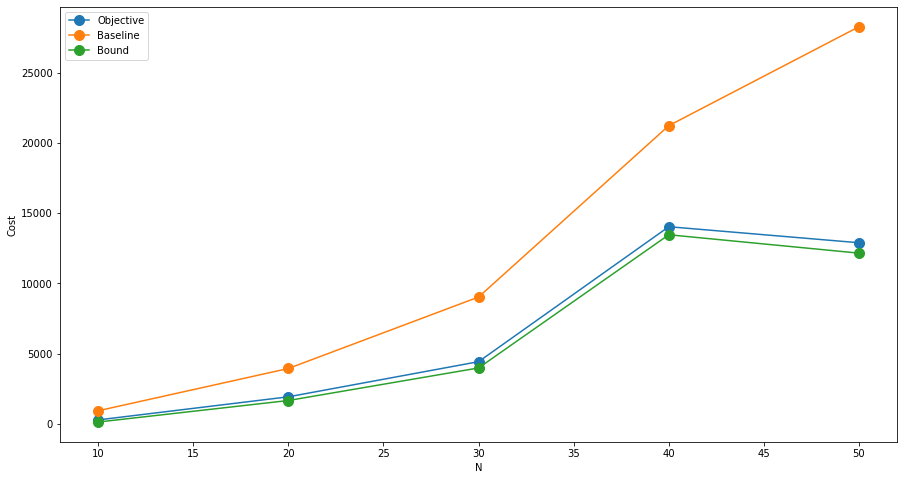

In [197]:
import pandas as pd
ax = pd.DataFrame({
    'Objective': obj_list,
    'Baseline': obj_baseline_list,
    'Bound': dual_bound_list,
}).set_index(pd.Series(N_list)).plot(figsize=(15, 8), markersize=10, marker='o')

ax.set_xlabel('N');
ax.set_ylabel('Cost');
ax.legend();

In [199]:
fig, ax = problem.subproblem_1.visualize_flow(figsize=(16,20))
fig.savefig('with_charging.png')

In [201]:
baseline.problem.visualize_flow(figsize=(16,20))
fig.savefig('without_charging.png')

In [ ]:
problem.pD

array([ 0.        , 38.75      , 16.75      ,  0.        ,  0.        ,
       20.25      ,  0.        ,  0.        ,  0.        ,  7.66666667,
        0.        , 19.75      ,  0.        ,  0.        , 43.2       ,
       38.2       ,  0.        ,  0.        ,  0.        , 21.        ,
       31.25      ,  0.        ,  0.        ,  0.        ,  0.        ,
       22.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , 12.5       , 10.        , 43.4       ,  6.25      ,
        0.        ,  0.        ,  0.        , 26.8       ,  0.        ,
       20.5       ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  6.25      ,  0.        ,  0.        ,  0.        ])

In [ ]:
baseline.pD

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])